Example fMRI subject-level GLM model fitting
================================================

Full step-by-step example of fitting a subject-level GLM to experimental data and visualizing
the results. We first do this on one runs of one subject of an fMRI dataset for motor functions. These data were downloaded in BIDS format from https://openneuro.org/datasets/ds000114/versions/1.0.1 and were preprocessed using fmriprep.

For details on the data, please see:

Gorgolewski K J, Storkey A, Bastin M, Whittle I R, Wardlaw J M, Pernet C R. A test-retest fMRI dataset for motor, language and spatial attention functions. Gigascience. 2013: 2:6.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3641991/

More specifically:

1. A sequence of preprocessed fMRI volumes are loaded
2. A design matrix describing all the effects related to the data is computed
3. A GLM is applied to the run of the dataset, contrasts are computed, and results are visualized
4. A example for loop is shown to loop this analysis across runs and across subjects

Technically, this example shows how to handle two sessions that
contain the same experimental conditions.

# Task Description

This dataset was acquired to validate an fMRI task used in pre-surgical planning. Different motor tasks activate different areas of the brain and surgons need to have reliable information about where these areas are located before conducting neurosurgical procedures. 

The task consisted of finger tapping, foot twitching and lip pursing blocks that were interleaved with fixation.

# Single Subject GLM

First, we use PyBIDS to import the preprocessed BIDS data

In [1]:
# Import preprocessed BIDS dataset
from bids.layout import BIDSLayout
from os import path

data_dir = '/scratch/cis-training/'
layout = BIDSLayout(path.join(data_dir, 'ds000114/'), 
                    derivatives='/scratch/cis-training/ds000114/derivatives/')
events_file = layout.get(task='fingerfootlips', suffix='events')[0]
events_file = events_file.path

We query the preprocessed BIDS dataset and grab the nifti files for each run from one subject:

In [2]:
func_files = layout.get(
    sub='01', datatype='func', task='fingerfootlips',
    space='MNI152NLin2009cAsym', desc='preproc',
    extension='nii.gz')
print(func_files)

[<BIDSImageFile filename='/scratch/cis-training/ds000114/derivatives/fmriprep/sub-01/ses-retest/func/sub-01_ses-retest_task-fingerfootlips_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'>, <BIDSImageFile filename='/scratch/cis-training/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'>]


Create a mean image of the run for plotting purpose

In [3]:
%matplotlib inline

from nilearn.image import mean_img
mean_img_ = mean_img(func_files[0].path)

from nilearn import plotting
plotting.plot_img(mean_img_)

The timing file describing each conditon is:

In [4]:
import pandas as pd
events_df = pd.read_csv(events_file, sep='\t')
events_df.head()

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot


We want to include nuisance regressors in our design matrix, so we search for potential confound files that were created as part of fmriprep's preprocessing.

In [5]:
# Find the confounds file
temp_entities = func_files[0].get_entities()
temp_entities['suffix'] = 'regressors'
temp_entities['extension'] = 'tsv'
temp_entities['desc'] = 'confounds'
temp_entities.pop('space')

confounds_file = layout.get(**temp_entities)[0].path
confounds = pd.read_csv(confounds_file, sep='\t')

The possible confounds we have to choose from are:

In [6]:
for c in confounds.columns:
    print(c)

csf
csf_derivative1
csf_power2
csf_derivative1_power2
white_matter
white_matter_derivative1
white_matter_power2
white_matter_derivative1_power2
global_signal
global_signal_derivative1
global_signal_derivative1_power2
global_signal_power2
std_dvars
dvars
framewise_displacement
t_comp_cor_00
t_comp_cor_01
t_comp_cor_02
t_comp_cor_03
t_comp_cor_04
t_comp_cor_05
a_comp_cor_00
a_comp_cor_01
a_comp_cor_02
a_comp_cor_03
a_comp_cor_04
a_comp_cor_05
a_comp_cor_06
a_comp_cor_07
a_comp_cor_08
a_comp_cor_09
a_comp_cor_10
a_comp_cor_11
a_comp_cor_12
a_comp_cor_13
a_comp_cor_14
a_comp_cor_15
a_comp_cor_16
a_comp_cor_17
a_comp_cor_18
a_comp_cor_19
a_comp_cor_20
a_comp_cor_21
a_comp_cor_22
a_comp_cor_23
a_comp_cor_24
a_comp_cor_25
a_comp_cor_26
a_comp_cor_27
a_comp_cor_28
a_comp_cor_29
a_comp_cor_30
a_comp_cor_31
a_comp_cor_32
a_comp_cor_33
a_comp_cor_34
a_comp_cor_35
a_comp_cor_36
a_comp_cor_37
a_comp_cor_38
a_comp_cor_39
a_comp_cor_40
a_comp_cor_41
a_comp_cor_42
a_comp_cor_43
a_comp_cor_44
a_comp_co

We'ge going to regress out six motion parameters (3 translation and 3 rotation) as well as any volumes that were flagged by DVARS. Here we create these confounds for the model.

In [7]:
cols = ['trans_x', 'trans_y', 'trans_z', 
        'rot_x', 'rot_y', 'rot_z', 'dvars']

func_file = func_files[0]
temp_entities = func_file.get_entities()
temp_entities['suffix'] = 'regressors'
temp_entities['extension'] = 'tsv'
temp_entities['desc'] = 'confounds'
temp_entities.pop('space')

confounds_file = layout.get(**temp_entities)[0].path
confounds = pd.read_csv(confounds_file, sep='\t')

confounds_for_model = confounds[cols]
confounds_for_model = confounds_for_model.fillna(0)

Define the subject-level model.

In [8]:
from nistats.first_level_model import FirstLevelModel

t_r = layout.get_metadata(func_files[0].path)['RepetitionTime']
model = FirstLevelModel(t_r=t_r, period_cut=128, 
                        subject_label=func_files[0].entities['subject'], 
                        smoothing_fwhm=5., drift_model = 'polynomial', 
                        noise_model='ar1', minimize_memory=True)

Run the model

In [9]:
model.fit(func_file.path, events_df, confounds_for_model)

/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:

FirstLevelModel(drift_model='polynomial', drift_order=1, fir_delays=[0],
        hrf_model='glover', mask=None, memory=Memory(location=None),
        memory_level=1, min_onset=-24, minimize_memory=True, n_jobs=1,
        noise_model='ar1', period_cut=128, signal_scaling=True,
        slice_time_ref=0.0, smoothing_fwhm=5.0, standardize=False,
        subject_label='01', t_r=2.5, target_affine=None, target_shape=None,
        verbose=0)

Visualize the design matrix

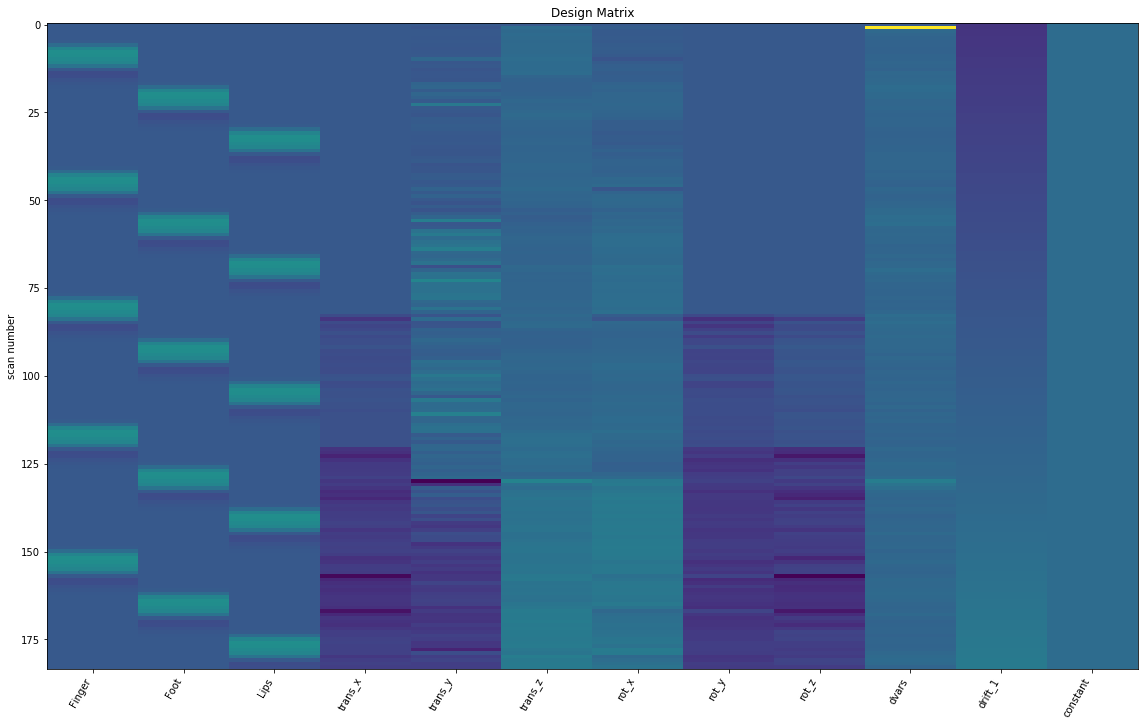

In [10]:
%matplotlib inline

from nistats.reporting import plot_design_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 10))
plot_design_matrix(model.design_matrices_[0], ax=ax)
ax.set_title('Design Matrix')
fig.show()

Build and plot the contrasts

In [11]:
import numpy as np

def pad_vector(contrast_, n_columns):
    return np.hstack((contrast_, np.zeros(n_columns - len(contrast_))))

In [12]:
n_columns = model.design_matrices_[0].shape[1]
contrasts = {
    'Finger_minus_All': pad_vector([1, -0.5, -0.5], n_columns),
    'Foot_minus_All': pad_vector([-0.5, 1, -0.5], n_columns)
}

/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


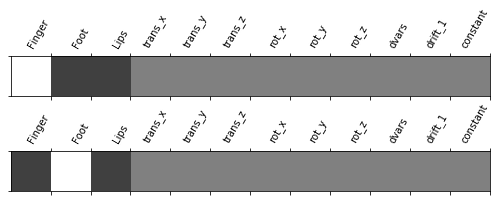

In [13]:
from nistats.reporting import plot_contrast_matrix

plt.figure(figsize=(7, 7))
for i, (key, values) in enumerate(contrasts.items()):
    ax = plt.subplot(5, 1, i + 1)
    plot_contrast_matrix(values, design_matrix=model.design_matrices_[0], ax=ax)

plt.show()

Compute the contrasts and plot up the within-run, subject-level results

01
		Contrast 1 out of 2: Finger_minus_All


/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


		Contrast 2 out of 2: Foot_minus_All


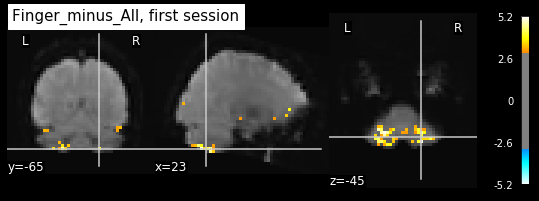

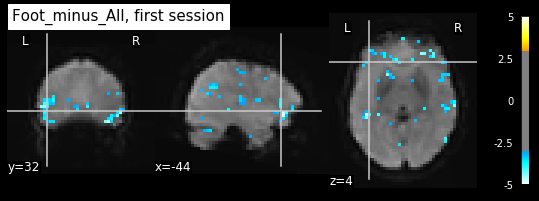

In [14]:
sub = '01'
ses = layout.get_sessions(subjects=sub)[0]
print(sub)
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('\t\tContrast {} out of {}: {}'.format(index+1, 
                                                 len(contrasts), 
                                                 contrast_id))
    pe_map = model.compute_contrast(contrast_val, 
                                    output_type='effect_size')
    pe_image_file = 'sub-{}_ses-{}_{}_pe_map.nii.gz'.format(sub, 
                                                            ses, 
                                                            contrast_id)
    pe_map.to_filename(pe_image_file)

    z_map = model.compute_contrast(contrast_val, output_type='z_score')
    z_image_file = 'sub-{}_ses-{}_{}_z_map.nii.gz'.format(sub, 
                                                          ses, 
                                                          contrast_id)
    z_map.to_filename(z_image_file)
    
    plotting.plot_stat_map(
    z_map, bg_img=mean_img_, threshold=3.0,
    title='%s, first session' % contrast_id)

The above cells ran the analysis for a sigle rub for a single subject. The following code accomplishes what above cells did but also loops through mulitple runs and multiple participants so that first-level analyses are performed for all subjects in the study.

Subject: 01
	Session retest


/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


		Contrast 1 out of 2: Finger_minus_All


/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


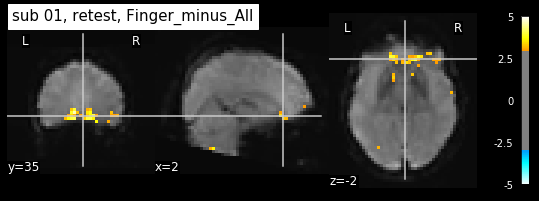

		Contrast 2 out of 2: Foot_minus_All


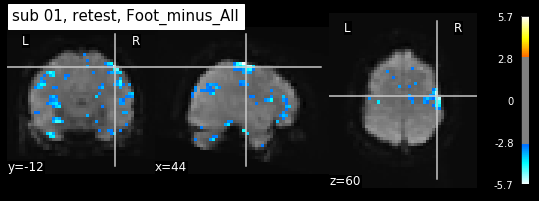

	Session test


/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


		Contrast 1 out of 2: Finger_minus_All


/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


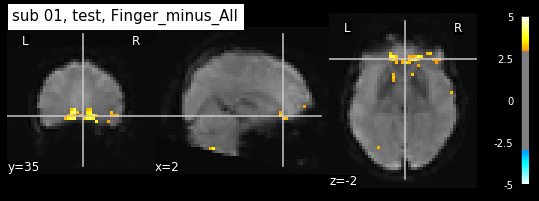

		Contrast 2 out of 2: Foot_minus_All


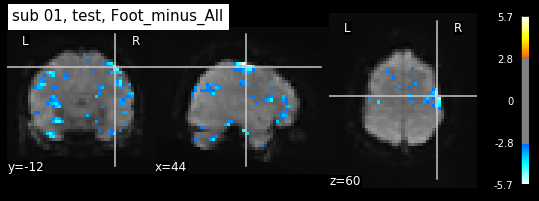

In [15]:
# Loop through participants
cols = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars']

events_file = layout.get(task='fingerfootlips', suffix='events')[0]
events_df = pd.read_csv(events_file, sep='\t')

for sub in layout.get_subjects()[:1]:
    print('Subject: {}'.format(sub))
    func_files = []
    confounds = []

    for ses in layout.get_sessions(subjects=sub):
        print('\tSession {}'.format(ses))
        func_file = layout.get(
            sub=sub, ses=ses, datatype='func', task='fingerfootlips',
            space='MNI152NLin2009cAsym', desc='preproc',
            extension='nii.gz')[0]
        func_files.append(func_file.path)

        # Search for confounds file
        temp_entities = func_file.get_entities()
        temp_entities['suffix'] = 'regressors'
        temp_entities['extension'] = 'tsv'
        temp_entities['desc'] = 'confounds'
        temp_entities.pop('space')

        confounds_file = layout.get(**temp_entities)[0].path
        confounds_df = pd.read_csv(confounds_file, sep='\t')

        confounds_for_model = confounds_df[cols]
        confounds_for_model = confounds_for_model.fillna(0)
        confounds.append(confounds_for_model)
        
        # Build model that runs across sessions
        t_r = layout.get_metadata(func_file.path)['RepetitionTime']
        model = FirstLevelModel(t_r=t_r, subject_label=temp_entities['subject'], smoothing_fwhm=5.)
        model.fit(func_file.path, events_df, confounds_for_model)
    
        # Build contrasts
        n_columns = model.design_matrices_[0].shape[1]
        contrasts = {
            'Finger_minus_All': pad_vector([1, -0.5, -0.5], n_columns),
            'Foot_minus_All': pad_vector([-0.5, 1, -0.5], n_columns)
        }
        
        # Compute contrasts and plot results
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            print('\t\tContrast {} out of {}: {}'.format(index+1, len(contrasts), contrast_id))
            pe_map = model.compute_contrast(contrast_val, output_type='effect_size')
            pe_image_file = 'sub-{}_ses-{}_{}_pe_map.nii.gz'.format(sub, ses, contrast_id)
            pe_map.to_filename(pe_image_file)

            z_map = model.compute_contrast(contrast_val, output_type='z_score')
            z_image_file = 'sub-{}_ses-{}_{}_z_map.nii.gz'.format(sub, ses, contrast_id)
            z_map.to_filename(z_image_file)
            
            plotting.plot_stat_map(z_image_file, bg_img=mean_img_, threshold=3.0, 
                                   title='sub {0}, {1}, {2}'.format(sub,ses,contrast_id))
            plt.show()
            
            
            
            

We can also average across both runs:

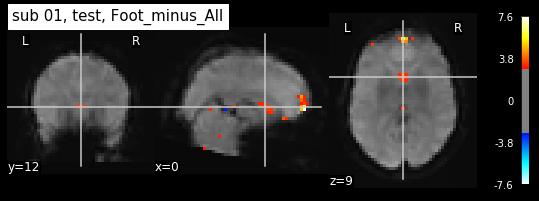

In [16]:
from nilearn import image

files = ['sub-01_ses-test_Finger_minus_All_pe_map.nii.gz',
         'sub-01_ses-retest_Finger_minus_All_pe_map.nii.gz']
level2_pe_map = image.mean_img(files)
level2_pe_map.to_filename('sub-{}_Finger_minus_All_pe_map.nii.gz'.format('01'))
plotting.plot_stat_map(level2_pe_map, bg_img=mean_img_, 
                       threshold=3.0, title='sub {0}, {1}, {2}'.format(sub,ses,contrast_id))